In [ ]:
# Please make 10 TIFF binary pixel mask files for each case;

#     Filename:      '{:03d}.tif' (each case number must match to the provided slide id number.)
#     ImageSize:    corresponding to the original WSI's level 0 dimension
#     Datatype:      uint 8 (consist of 0 and 1)
#     LabelNum:    assign 1 for predicted pixels of viable tumor, 0 for those of non-tumor or backgrounds
#     Compression:  ADOBE_DEFLATE level 9 (See https://github.com/paip-2019/challenge)

### Generate output binary masks for validation dataset
* Chop each image into tiles remembering some info for later ensembling
* Feed the tiles to the network in batches
* Get predicted output for each tiles
* Merge tiles together to create the mask for the entire image

In [ ]:
# Problems
# * how to preserve level_0 dimensions of the original slides; so I need to chop the slides into 
# * does it matter if channels are in reverse order
# * 

In [4]:
############
# SETTINGS #
############

data_name = 'paip2019'
train_set_path = 'D:\work2019-2020\PAIP_2019\data\TrainingData\*zip'
input_path = 'D:\work2019-2020\PAIP_2019\data\ValidationData\*svs'

viable_output_path = 'D:\work2019-2020\PAIP_2019\data\Output\Viable'
whole_output_path = 'D:\work2019-2020\PAIP_2019\data\Output\Whole'

train_output_path = 'D:\work2019-2020\PAIP_2019\data\TrainOutput'
val_images_path = 'D:\work2019-2020\PAIP_2019\data\VisualizeResults'
liver_images_temp_path = 'D:\work2019-2020\PAIP_2019\data\TempLiverImages'
gpuid = 0

resize = 1.
patch_size = 256
stride_size = patch_size // 2
batch_size = 10

In [19]:
import os
import glob
import numpy as np
import cv2
import torch
import sklearn.feature_extraction.image
import openslide
from openslide import OpenSlide, OpenSlideUnsupportedFormatError, OpenSlideError
import matplotlib.pyplot as plt
from skimage import io, transform
import zipfile
from pydaily import filesystem
import scipy.misc
from PIL import Image
from tifffile import imsave
from unet import UNet

In [6]:
device = torch.device(gpuid if torch.cuda.is_available() else 'cpu')

In [7]:
# get *.svs files
val_files = glob.glob(input_path)
val_files.sort()
#len(val_files)

In [8]:
train_files = glob.glob(train_set_path)
train_files.sort()
len(train_files)

50

In [14]:
# helper functions

def unzip_file(zip_file_path, unzip_temp_dir=liver_images_temp_path):
    """
        Unzips file from specified location to a temporary location
        Args:
            zip_file_path: path of the zip file to be decompressed
    """
    filesystem.overwrite_dir(unzip_temp_dir) # overwrite directory
    zip_ref = zipfile.ZipFile(zip_file_path, 'r')
    zip_ref.extractall(unzip_temp_dir)
    zip_ref.close()

def get_file_id(fname):
    return os.path.basename(fname)[-7:-4]

def load_slide(fname):
    """
        Open a whole-slide image (*.svs file)        
        Args:
            fname (string): file path for the wsi file            
        Returns:
            OpenSlide object
    """    
    try:
        slide = OpenSlide(fname)
    except OpenSlideError:
        slide = None
    except FileNotFoundError:
        slide = None
    return slide

def load_mask(mask_path):
    """
        Function for loading liver masks (.tiff file).
        Args:
            mask_path (string): file path for mask images
        Returns:
            img_array (ndarray)
    """
    assert(os.path.isfile(mask_path))
    mask = io.imread(mask_path)
    print('mask shape:', mask.shape)
    return mask

def slide_info(slide_id, slide):
    """
        Print information about one single slide.
    """
    
    print(f'Info for WSI: {slide_id}')
    print(f'  Level count: {slide.level_count}')
    print(f'  Level dimensions: {slide.level_dimensions}')
    print(f'  Level downsamples: {slide.level_downsamples}')
    print(f'  Dimensions: {slide.dimensions}')
    objective_power = int(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
    print(f'Objective power: {objective_power}')
    
def visualize_slide(slide_id, slide):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))    
    ax1.imshow(slide)
    ax1.set_title('Slide Image') 
    plt.tight_layout()
    plt.savefig(f'{val_images_path}\{slide_id}.png')
    plt.show()
    
def visualize_mask(mask_id, mask):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))    
    ax1.imshow(mask)
    ax1.set_title('Generated Mask') 
    plt.tight_layout()
    plt.savefig(f'{val_images_path}\mask_{mask_id}.png')
    plt.show()
    
def visualize_mask_n_slide(slide_id, slide, mask, output_path):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))    
    
    ax1.imshow(slide)
    ax1.set_title('Slide Image')
    
    ax2.imshow(mask)
    ax2.set_title('Generated Mask')    
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

def visualize_mask_gt(slide_id, predicted_mask, target):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))    
    
    ax1.imshow(predicted_mask)
    ax1.set_title('Predicted mask')
    
    ax2.imshow(target)
    ax2.set_title('Ground truth')    
    
    plt.tight_layout()
    #plt.savefig(f'{val_images_path}\{slide_id}_mask.png')
    plt.show()
    
    
def resize_slide(slide, display_level=2):
    new_size = (slide.level_dimensions[display_level][0], slide.level_dimensions[display_level][1]) 
    slide = np.asarray(slide.read_region((0, 0), display_level, slide.level_dimensions[display_level]))[:,:,:3]
    #print(slide.shape)
    return slide


In [15]:
def jaccard_similarity(prediction, target, eps=1e-6):
    prediction = prediction == 1
    target = target == np.amax(target)
    
    inter = np.sum((prediction+target)==2)
    union = np.sum((prediction+target)>=1)
    
    result = float(inter) / (float(union) + eps)
    
    return result

Info for WSI: 105
  Level count: 3
  Level dimensions: ((53783, 41434), (13445, 10358), (3361, 2589))
  Level downsamples: (1.0, 4.000208109372095, 16.002972604325006)
  Dimensions: (53783, 41434)
Objective power: 20
(2589, 3361, 3)


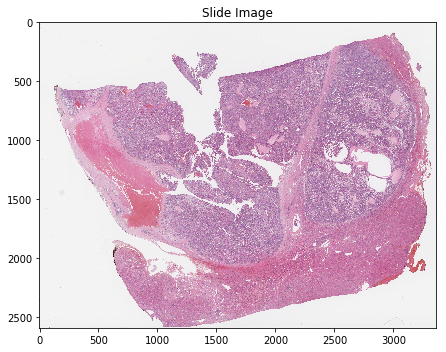

Info for WSI: 140
  Level count: 3
  Level dimensions: ((52174, 47016), (13043, 11754), (3260, 2938))
  Level downsamples: (1.0, 4.000076669477881, 16.003508709651825)
  Dimensions: (52174, 47016)
Objective power: 20
(2938, 3260, 3)


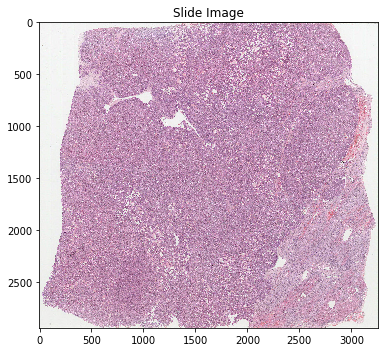

Info for WSI: 141
  Level count: 3
  Level dimensions: ((59760, 47064), (14940, 11766), (3735, 2941))
  Level downsamples: (1.0, 4.0, 16.001360081604897)
  Dimensions: (59760, 47064)
Objective power: 20
(2941, 3735, 3)


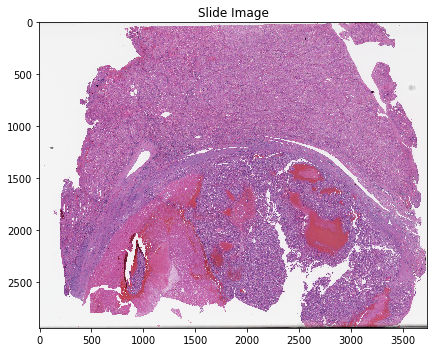

Info for WSI: 142
  Level count: 3
  Level dimensions: ((61751, 47559), (15437, 11889), (3859, 2972))
  Level downsamples: (1.0, 4.000223336184249, 16.002084628860466)
  Dimensions: (61751, 47559)
Objective power: 20
(2972, 3859, 3)


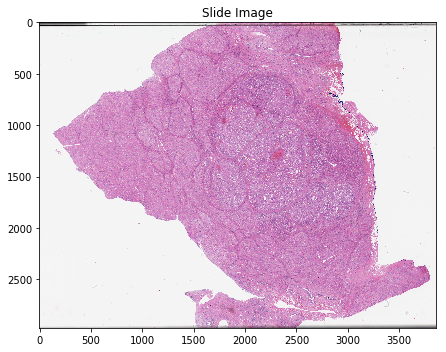

Info for WSI: 143
  Level count: 4
  Level dimensions: ((61170, 50638), (15292, 12659), (3823, 3164), (1911, 1582))
  Level downsamples: (1.0, 4.0001443888511865, 16.0024739640601, 32.00913435489921)
  Dimensions: (61170, 50638)
Objective power: 20
(3164, 3823, 3)


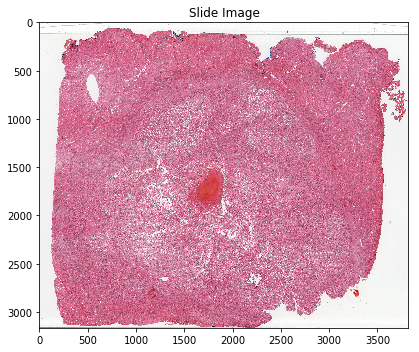

Info for WSI: 144
  Level count: 3
  Level dimensions: ((57768, 45546), (14442, 11386), (3610, 2846))
  Level downsamples: (1.0, 4.000087827156157, 16.00286488496271)
  Dimensions: (57768, 45546)
Objective power: 20
(2846, 3610, 3)


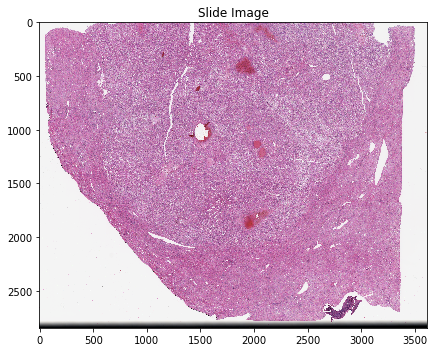

Info for WSI: 145
  Level count: 3
  Level dimensions: ((45815, 42031), (11453, 10507), (2863, 2626))
  Level downsamples: (1.0, 4.000273732019727, 16.004078548723783)
  Dimensions: (45815, 42031)
Objective power: 20
(2626, 2863, 3)


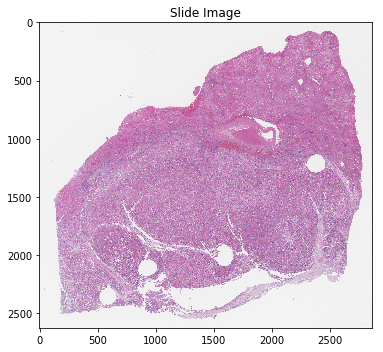

Info for WSI: 150
  Level count: 3
  Level dimensions: ((57767, 45562), (14441, 11390), (3610, 2847))
  Level downsamples: (1.0, 4.000191667235621, 16.00272576371882)
  Dimensions: (57767, 45562)
Objective power: 20
(2847, 3610, 3)


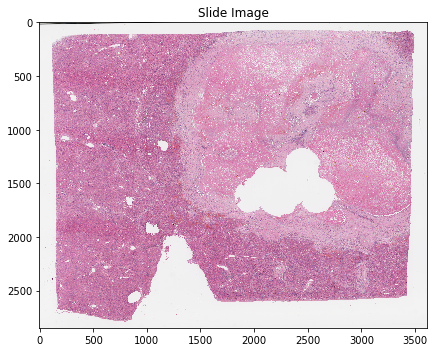

Info for WSI: 159
  Level count: 3
  Level dimensions: ((59759, 40361), (14939, 10090), (3734, 2522))
  Level downsamples: (1.0, 4.000149962341072, 16.003792868074285)
  Dimensions: (59759, 40361)
Objective power: 20
(2522, 3734, 3)


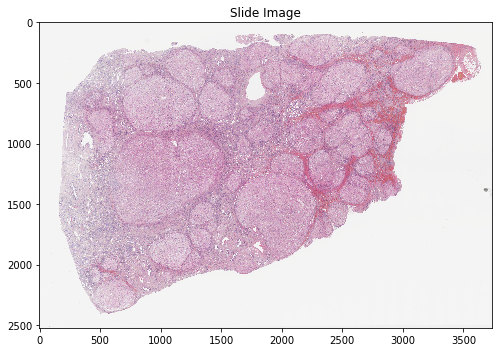

Info for WSI: 161
  Level count: 3
  Level dimensions: ((63744, 45993), (15936, 11498), (3984, 2874))
  Level downsamples: (1.0, 4.000043485823621, 16.001565762004176)
  Dimensions: (63744, 45993)
Objective power: 20
(2874, 3984, 3)


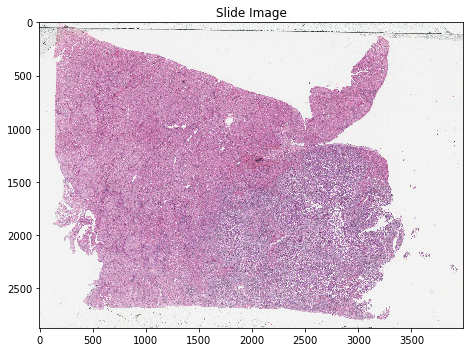

In [79]:
slide_orig_size = {}
for i, fname in enumerate(files):    
    slide = load_slide(fname)
    slide_orig_size[i] = slide.dimensions
    slide_id = get_file_id(fname)
    slide_info(slide_id, slide)
    slide = resize_slide(slide)
    visualize_slide(slide_id, slide)

In [10]:
def divide_batch(l, n): 
    for i in range(0, l.shape[0], n):  
        yield l[i:i + n,::]

**Load Model**

In [19]:
def load_network(model_path, model_type, task='viable'):
    """
        Function to load specified model.
        Args:
            model_type (str): type of the model
            task (str): type of segmentation (viable/whole)
        Returns:
            model (object of model_type): the 
    """
    print(model_path)
    
    device = torch.device(gpuid if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    
    if model_type == 'unet':             
        model = UNet(n_classes=checkpoint["n_classes"],\
                     in_channels=checkpoint["in_channels"],\
                     padding=checkpoint["padding"],\
                     depth=checkpoint["depth"],\
                     wf=checkpoint["wf"],\
                     up_mode=checkpoint["up_mode"],\
                     batch_norm=checkpoint["batch_norm"]).to(device)
    model.load_state_dict(checkpoint["model_dict"])
    model.eval()    
    print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
    return model, checkpoint

In [10]:
def generate_masks(task):
    model, checkpoint = load_network('unet', task)
    
    for (i, fname) in enumerate(train_files):
        fname = fname.strip()
        print(fname)        
        unzip_file(fname)
        slide_id = get_file_id(fname)
        slide_path = glob.glob(os.path.join(liver_images_temp_path, '*.svs'))[0]
        viable_path = glob.glob(os.path.join(liver_images_temp_path, '*viable.tif'))[0]
        print(slide_id)
        
        outfname = "%s/%s.tif" % (train_output_path, slide_id)
        print(f"working on file: \t {fname}")
        print(f"saving to : \t {outfname}")
    
        cv2.imwrite(outfname, np.zeros(shape=(1, 1)))
    
        slide = load_slide(slide_path)
        level0_size = (slide.level_dimensions[0][0], slide.level_dimensions[0][1])
        print(f'level 0 dimensions {level0_size}')
        
        viable_mask = load_mask(viable_path)
        viable_mask = cv2.resize(viable_mask, level0_size)
        print(f'viable mask shape{viable_mask.shape}')
        
        slide = resize_slide(slide)        
        slide = cv2.resize(slide, (0, 0), fx=resize, fy=resize)

        slide_shape_orig = np.array(slide.shape)
    
        #add half the stride as padding around the image, so that we can crop it away later
        slide = np.pad(slide, [(stride_size//2, stride_size//2), (stride_size//2, stride_size//2), (0, 0)], mode="reflect")
        slide_shape_wpad = np.array(slide.shape)
    
        #pad to match an exact multiple of unet patch size, otherwise last row/column are lost
        npad0 = int(np.ceil(slide_shape_wpad[0] / patch_size) * patch_size - slide_shape_wpad[0])
        npad1 = int(np.ceil(slide_shape_wpad[1] / patch_size) * patch_size - slide_shape_wpad[1])
        slide = np.pad(slide, [(0, npad0), (0, npad1), (0, 0)], mode="constant")

        tiles = sklearn.feature_extraction.image.extract_patches(slide, (patch_size, patch_size, 3), stride_size)
        tiles_shape = tiles.shape
        tiles = tiles.reshape(-1, patch_size, patch_size, 3)

        #in case we have a large network, lets cut the list of tiles into batches
        output = np.zeros((0, checkpoint["n_classes"], patch_size, patch_size))
        
        for X in divide_batch(tiles, batch_size):
        
            X = torch.from_numpy(X.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

            # ---- get results
            output_batch = model(X)

            # --- pull from GPU and append to rest of output 
            output_batch = output_batch.detach().cpu().numpy()        
            output = np.append(output, output_batch, axis=0)


        output = output.transpose((0, 2, 3, 1))
    
        #turn from a single list into a matrix of tiles
        output = output.reshape(tiles_shape[0], tiles_shape[1], patch_size, patch_size, output.shape[3])

        #remove the padding from each tile, we only keep the center
        output = output[:,:,stride_size//2:-stride_size//2,stride_size//2:-stride_size//2,:]

        #turn all the tiles into an image
        output=np.concatenate(np.concatenate(output,1),1)
    
        #incase there was extra padding to get a multiple of patch size, remove that as well
        output = output[0:slide_shape_orig[0], 0:slide_shape_orig[1], :] #remove paddind, crop back

        # --- save output

        # cv2.imwrite(newfname_class, (output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)).astype(np.uint8))
        output = output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)
        output = Image.fromarray(output.astype('uint8'))
        output = np.array(output.resize(level0_size))
        print(type(output))
        print(output.shape)
        print(f'Jaccard similarity: {jaccard_similarity(output, viable_mask)}')
        #print(slide_orig_size[i])
        #transform.resize(output, slide_orig_size[i])
        
        cv2.imwrite(outfname, output)

In [32]:
def generate_validation_results(task):
    model_path = f'./models/paip2019_unet_best_model_viable_tumor_256_2.pth'
    model, checkpoint = load_network(model_path, 'unet', task)
    
    for (i, fname) in enumerate(val_files):
        fname = fname.strip()
        slide_id = get_file_id(fname)
        print(f"working on file: \t {fname}")
        outfname = "%s/%s.tif" % (viable_output_path, slide_id)
        print(f"saving to : \t {outfname}")       
        print(slide_id)                      
    
        cv2.imwrite(outfname, np.zeros(shape=(1, 1)))
    
        slide = load_slide(fname)
        level0_size = (slide.level_dimensions[0][0], slide.level_dimensions[0][1])
        print(f'level 0 dimensions {level0_size}')
        
        slide = resize_slide(slide)        
        slide = cv2.resize(slide, (0, 0), fx=resize, fy=resize)

        slide_shape_orig = np.array(slide.shape)
    
        #add half the stride as padding around the image, so that we can crop it away later
        slide = np.pad(slide, [(stride_size//2, stride_size//2), (stride_size//2, stride_size//2), (0, 0)], mode="reflect")
        slide_shape_wpad = np.array(slide.shape)
    
        #pad to match an exact multiple of unet patch size, otherwise last row/column are lost
        npad0 = int(np.ceil(slide_shape_wpad[0] / patch_size) * patch_size - slide_shape_wpad[0])
        npad1 = int(np.ceil(slide_shape_wpad[1] / patch_size) * patch_size - slide_shape_wpad[1])
        slide = np.pad(slide, [(0, npad0), (0, npad1), (0, 0)], mode="constant")

        tiles = sklearn.feature_extraction.image.extract_patches(slide, (patch_size, patch_size, 3), stride_size)
        tiles_shape = tiles.shape
        tiles = tiles.reshape(-1, patch_size, patch_size, 3)

        #in case we have a large network, lets cut the list of tiles into batches
        output = np.zeros((0, checkpoint["n_classes"], patch_size, patch_size))
        
        for X in divide_batch(tiles, batch_size):
        
            X = torch.from_numpy(X.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

            # ---- get results
            output_batch = model(X)

            # --- pull from GPU and append to rest of output 
            output_batch = output_batch.detach().cpu().numpy()        
            output = np.append(output, output_batch, axis=0)


        output = output.transpose((0, 2, 3, 1))
    
        #turn from a single list into a matrix of tiles
        output = output.reshape(tiles_shape[0], tiles_shape[1], patch_size, patch_size, output.shape[3])

        #remove the padding from each tile, we only keep the center
        output = output[:,:,stride_size//2:-stride_size//2,stride_size//2:-stride_size//2,:]

        #turn all the tiles into an image
        output=np.concatenate(np.concatenate(output,1),1)
    
        #incase there was extra padding to get a multiple of patch size, remove that as well
        output = output[0:slide_shape_orig[0], 0:slide_shape_orig[1], :] #remove paddind, crop back

        # --- save output

        # cv2.imwrite(newfname_class, (output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)).astype(np.uint8))
        output = output.argmax(axis=2) * (256 / (output.shape[-1] - 1) - 1)
        output = Image.fromarray(output.astype('uint8'))
        
        # resize the generated mask to match the conditions of the competition
        output = output.resize(level0_size)
        #print(type(output))
        print(f'predicted output image shape: {output.size}')
        output = np.asarray(output)
        print(f'predicted output shape: {output.shape}')
        #print(f'Jaccard similarity: {jaccard_similarity(output, viable_mask)}')
        #print(slide_orig_size[i])
        #transform.resize(output, slide_orig_size[i])
        
        cv2.imwrite(outfname, output)

In [33]:
generate_validation_results('viable')

./models/paip2019_unet_best_model_viable_tumor_256_2.pth
total params: 	122466
working on file: 	 D:\work2019-2020\PAIP_2019\data\ValidationData\01_01_0105.svs
saving to : 	 D:\work2019-2020\PAIP_2019\data\Output\Viable/105.tif
105
level 0 dimensions (53783, 41434)


C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


predicted output image shape: (53783, 41434)
predicted output shape: (41434, 53783)
working on file: 	 D:\work2019-2020\PAIP_2019\data\ValidationData\01_01_0140.svs
saving to : 	 D:\work2019-2020\PAIP_2019\data\Output\Viable/140.tif
140
level 0 dimensions (52174, 47016)
predicted output image shape: (52174, 47016)
predicted output shape: (47016, 52174)
working on file: 	 D:\work2019-2020\PAIP_2019\data\ValidationData\01_01_0141.svs
saving to : 	 D:\work2019-2020\PAIP_2019\data\Output\Viable/141.tif
141
level 0 dimensions (59760, 47064)
predicted output image shape: (59760, 47064)
predicted output shape: (47064, 59760)
working on file: 	 D:\work2019-2020\PAIP_2019\data\ValidationData\01_01_0142.svs
saving to : 	 D:\work2019-2020\PAIP_2019\data\Output\Viable/142.tif
142
level 0 dimensions (61751, 47559)
predicted output image shape: (61751, 47559)
predicted output shape: (47559, 61751)
working on file: 	 D:\work2019-2020\PAIP_2019\data\ValidationData\01_01_0143.svs
saving to : 	 D:\work2

#### Visualize/Evaluate results

In [34]:
masks = glob.glob(os.path.join(train_output_path, '*.tif'))
masks.sort()

for i, mask_path in enumerate(masks):
    
    predicted_mask_id = get_file_id(mask_path)
    predicted_mask = load_mask(mask_path)
    print(f'predicted mask{predicted_mask_id} shape{predicted_mask.shape}')
    
    fname = train_files[i]   
    unzip_file(fname)
    target_path = glob.glob(os.path.join(liver_images_temp_path, '*viable.tif'))[0]
    target = load_mask(target_path)
    target = cv2.resize(target, (predicted_mask.shape[1], predicted_mask.shape[0]))
    print(f'target mask{get_file_id(fname)} shape{target.shape}')   
    
#     slide = load_slide(files[i])
#     visualize_slide(mask_id, slide)
#     visualize_maks_n_slide(mask_id, slide, mask)
    visualize_mask_gt(predicted_mask_id, predicted_mask, target)
    

KeyboardInterrupt: 

In [16]:
masks = glob.glob(os.path.join(viable_output_path, '*.tif'))
masks.sort()

predicted mask105 shape: (2589, 3361)
slide shape105 shape: (2589, 3361, 3)


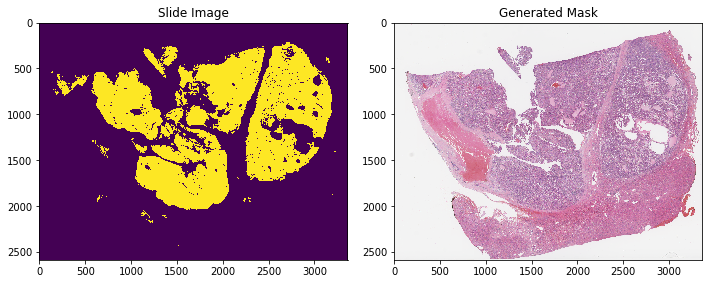

predicted mask140 shape: (2938, 3260)
slide shape140 shape: (2938, 3260, 3)


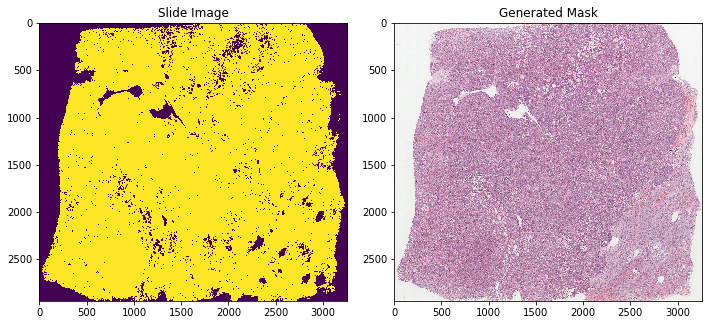

predicted mask141 shape: (2941, 3735)
slide shape141 shape: (2941, 3735, 3)


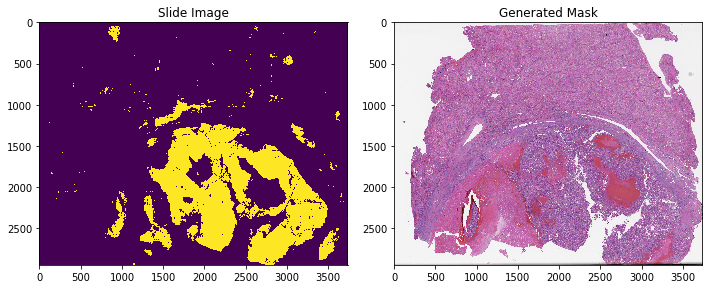

predicted mask142 shape: (2972, 3859)
slide shape142 shape: (2972, 3859, 3)


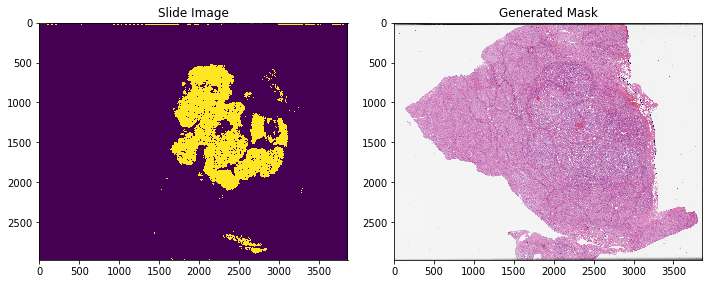

predicted mask143 shape: (3164, 3823)
slide shape143 shape: (3164, 3823, 3)


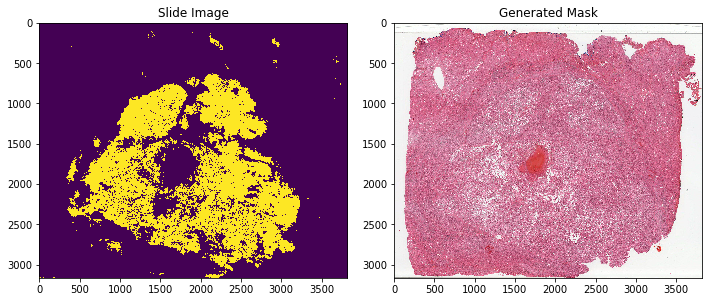

predicted mask144 shape: (2846, 3610)
slide shape144 shape: (2846, 3610, 3)


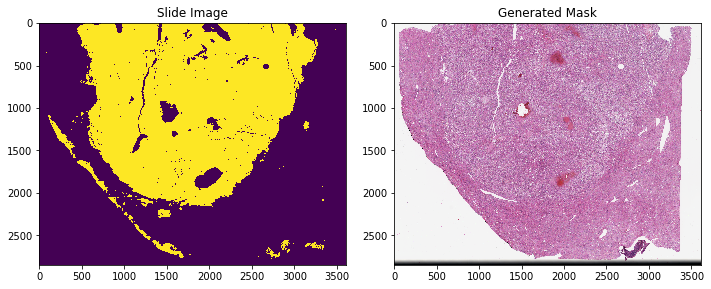

predicted mask145 shape: (2626, 2863)
slide shape145 shape: (2626, 2863, 3)


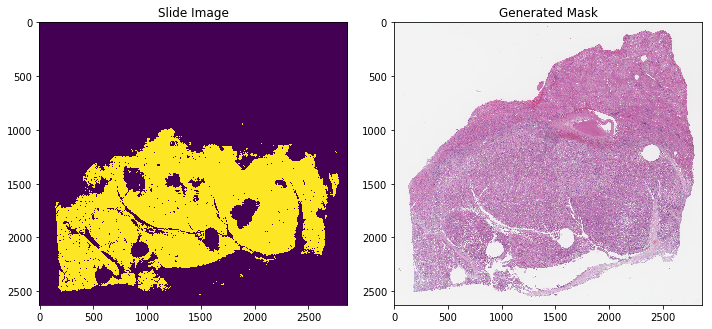

predicted mask150 shape: (2847, 3610)
slide shape150 shape: (2847, 3610, 3)


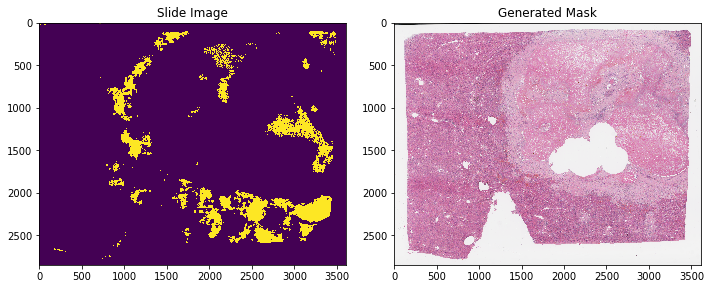

predicted mask159 shape: (2522, 3734)
slide shape159 shape: (2522, 3734, 3)


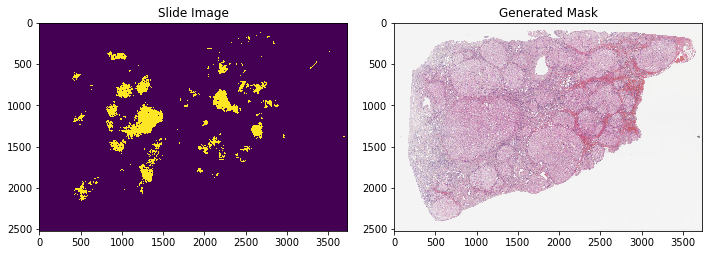

predicted mask161 shape: (2874, 3984)
slide shape161 shape: (2874, 3984, 3)


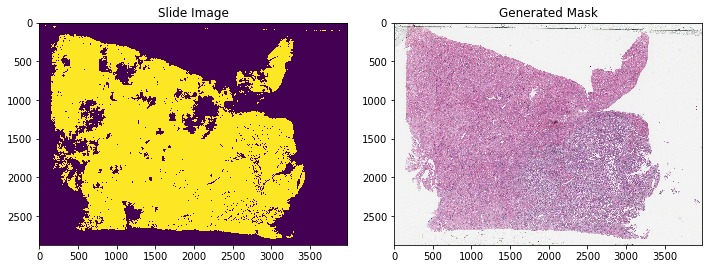

In [39]:
for i, mask_path in enumerate(masks):
    
    predicted_mask_id = get_file_id(mask_path)
    predicted_mask = load_mask(mask_path)
    
    slide_path = val_files[i]   
    slide = load_slide(slide_path)
    slide = resize_slide(slide)
    
    predicted_mask = cv2.resize(predicted_mask, (slide.shape[1], slide.shape[0]))
    print(f'predicted mask{predicted_mask_id} shape: {predicted_mask.shape}')
    print(f'slide shape{get_file_id(slide_path)} shape: {slide.shape}')   
    
#     slide = load_slide(files[i])
#     visualize_slide(mask_id, slide)
#     visualize_maks_n_slide(mask_id, slide, mask)
    visualize_mask_n_slide(predicted_mask_id, predicted_mask, slide, val_images_path)
    

In [20]:
# check required dimensions and compress according to the competition
for mask_path in masks:
    mask = load_mask(mask_path)
    mask = mask.astype(np.uint8) # NOTE: tifffile.imsave would show a 'bilevel'-related error w/o this explicit type casting

    # save with compression: ADOBE_DEFLATE algorithm with level 9 (among 0~9)
    # NOTE: the saving filename is the same with the loading filename. In other words, it may overwrite your original image.
    imsave(mask_path, mask, compress=9)

mask shape: (41434, 53783)
mask shape: (47016, 52174)
mask shape: (47064, 59760)
mask shape: (47559, 61751)
mask shape: (50638, 61170)
mask shape: (45546, 57768)
mask shape: (42031, 45815)
mask shape: (45562, 57767)
mask shape: (40361, 59759)
mask shape: (45993, 63744)
